# Trabalho de Introdução à Ciência de Dados - Equity in Athletics (Equidade no Atletismo)

## Membros
Cecília Junqueira - 2022094888

Carolina Pilla -2022043299


Felipe Gomide - 2022043213

Lucas Junqueira - 2022043264

## Informações 

* Base de dados do Departamentodde Educação dos E.U.A.: o [Equity in Athletics](https://ope.ed.gov/athletics/#/datafile/list) -  2006 à 2021
* A base engloba dados sobre equipes esportivas em faculdades americanas, considerando 43 esportes. Nosso foco é na receita (lucro e gastos) das faculdades e nas proporções de homens e mulheres.st

## Referências
* Best D1 Colleges. Disponível em: &#60;https://www.ncsasports.org/best-colleges/best-division-1-colleges&#62;. Acesso em: 16 ago. 2024. 
* 

## Setup Inicial

Instalação de biblioteca auxiliar e imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
#from adjustText import adjust_text
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

# Processamento dos Dados

## União dos dados de todos os anos

In [ ]:
df = pd.read_excel("https://github.com/FelipeGomide/ICD-EquityInAthletics/raw/master/dados/EADA_2006.xls")
df['YEAR'] = 2006

to_concat = []
to_concat.append(df)
for ano in range(2007, 2012):
    df_aux = pd.read_excel(f"https://github.com/FelipeGomide/ICD-EquityInAthletics/raw/master/dados/EADA_{ano}.xls")
    df_aux['YEAR'] = ano

    to_concat.append(df_aux)

for ano in range(2012, 2022):
    df_aux = pd.read_excel(f"https://github.com/FelipeGomide/ICD-EquityInAthletics/raw/master/dados/EADA_{ano}.xlsx")
    df_aux['YEAR'] = ano

    to_concat.append(df_aux)

df = pd.concat(to_concat)
df

## Seleção dos atributos de interesse

In [ ]:
#Seleção das colunas de interesse
aux = df[['SUM_PARTIC_MEN', 'SUM_PARTIC_WOMEN', 'Sports', 'YEAR', 'state_cd', 'TOTAL_OPEXP_INCLCOED', "SUM_TOTAL_HDCOACH", "SUM_TOTAL_ASSTCOACH", "TOTAL_REVENUE_ALL", "TOTAL_EXPENSE_ALL"]].reset_index(drop=True)

# Nova coluna, total de participantes
aux['TOTAL_PARTIC'] = aux['SUM_PARTIC_MEN'] + aux['SUM_PARTIC_WOMEN']

aux.shape

In [ ]:
# Modalidades com erro de digitação ou alguma mudança de categorização a partir dos anos
rename = {"Track and Field and Cross Country (combined)": "All Track Combined",
          "Swimming and Diving (combined)": "Swimming and Diving",
          "Field hocky": "Field Hockey"}


# Modalidades que já estão contidas em algum grupo serão removidas
to_drop = ["Track and Field, Indoor", "Track and Field, Outdoor", "Track and Field, X-Country",
           "Track and Field (Indoor)", "Track and Field (Outdoor)", "Swimming",
           "Synchronized Swimming", "Synchronized swimming", "Diving", "Cross Country",
            "Team Handball", "Table Tennis", "Badminton", "Archery", "Weight Lifting", "Rifle", # Esta linha: modalidades com menos de 10 mil atletas todos os anos
           "Other Sports"] # Conjunto de esportes, sem muita informação, possivelmente muito variados

aux = aux.replace(rename)
aux = aux[~aux['Sports'].isin(to_drop)]

In [ ]:
data = aux.groupby(by=['YEAR', 'Sports', 'state_cd']).sum().reset_index()
data.to_csv("tabelas_pre_processadas/modalidades_por_estado.csv", index=False)

Essa tabela será adicionada ao GitHub, para evitar o tempo de processamento de todos os dados, durante a realização das análises.

# Pergunta 1: Quais são as modalidades esportivas com maiores investimentos em comissão técnica e contratações?

Após uma análise mais minuciosa do conteúdo das tabelas, percebi que não existe informação suficiente pra quantificar esse tipo de investimento, apenas investimento no geral. Por isso, tive o enfoque nas diferenças de investimento total e no número de participantes de cada modalidade esportiva.

## Importando as tabelas

Tabela processada anteriormente do GitHub e tabela auxiliar com informações geográficas para desenho dos mapas.

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/FelipeGomide/ICD-EquityInAthletics/master/tabelas_pre_processadas/modalidades_por_estado.csv")
data = data.drop(columns = 'Unnamed: 0')

states = geopandas.read_file('https://raw.githubusercontent.com/joncutrer/geopandas-tutorial/master/data/usa-states-census-2014.shp')
states = states[['STUSPS','geometry','NAME']]

states['coords'] = states['geometry'].apply(lambda x: x.representative_point().coords[:])
states['coords'] = [coords[0] for coords in states['coords']]

states = states.drop_duplicates()
states

STUSPS                                           geometry  \
0      CA  MULTIPOLYGON Z (((-118.59397 33.4672 0, -118.4...   
1      DC  POLYGON Z ((-77.11976 38.93434 0, -77.04102 38...   
2      FL  MULTIPOLYGON Z (((-81.81169 24.56874 0, -81.75...   
3      GA  POLYGON Z ((-85.60516 34.98468 0, -85.47434 34...   
4      ID  POLYGON Z ((-117.24303 44.39097 0, -117.21507 ...   
5      IL  POLYGON Z ((-91.50617 40.20064 0, -91.49696 40...   
6      IA  POLYGON Z ((-96.62187 42.77926 0, -96.57794 42...   
7      KY  POLYGON Z ((-89.54443 36.57451 0, -89.47935 36...   
8      LA  POLYGON Z ((-94.04305 32.69303 0, -94.04303 32...   
9      MD  MULTIPOLYGON Z (((-76.04621 38.02553 0, -76.00...   
10     MI  MULTIPOLYGON Z (((-84.61622 45.89447 0, -84.51...   
11     MN  POLYGON Z ((-97.22904 49.00069 0, -96.93096 48...   
12     MO  POLYGON Z ((-95.76564 40.58521 0, -95.53318 40...   
13     NY  MULTIPOLYGON Z (((-72.01893 41.27411 0, -71.92...   
14     OR  POLYGON Z ((-124.55244 42.84057 0, -124.48094 ...   
15     TN  POLYGON Z ((-90.3007 35.02879 0, -90.2653 35.0...   
16     TX  POLYGON Z ((-106.62344 31.91403 0, -106.63011 ...   
17     VA  MULTIPOLYGON Z (((-76.02347 37.28907 0, -75.98...   
18     WI  MULTIPOLYGON Z (((-86.93428 45.42115 0, -86.83...   
19     AZ  POLYGON Z ((-114.79968 32.59362 0, -114.80939 ...   
20     AR  POLYGON Z ((-94.61792 36.49941 0, -94.3612 36....   
21     CO  POLYGON Z ((-109.05996 38.49999 0, -109.05996 ...   
22     IN  POLYGON Z ((-88.05947 37.86669 0, -88.04086 37...   
23     CT  POLYGON Z ((-73.69594 41.11526 0, -73.48271 41...   
24     NE  POLYGON Z ((-104.05314 41.11446 0, -104.05245 ...   
25     NM  POLYGON Z ((-109.0492 31.79655 0, -109.0483 32...   
26     NC  POLYGON Z ((-84.2866 35.20575 0, -84.28322 35....   
27     OH  MULTIPOLYGON Z (((-82.86334 41.69369 0, -82.82...   
28     ME  MULTIPOLYGON Z (((-68.92401 43.88541 0, -68.87...   
29     MA  MULTIPOLYGON Z (((-70.27553 41.31046 0, -70.19...   
30     MS  POLYGON Z ((-91.62136 31.26781 0, -91.56419 31...   
31     MT  POLYGON Z ((-116.04919 49.00091 0, -115.50102 ...   
32     OK  POLYGON Z ((-103.00252 36.67519 0, -103.00196 ...   
33     SC  POLYGON Z ((-83.35324 34.72865 0, -83.32006 34...   
34     SD  POLYGON Z ((-104.0577 44.99743 0, -104.03914 4...   
35     UT  POLYGON Z ((-114.05247 37.60478 0, -114.05247 ...   
36     WA  MULTIPOLYGON Z (((-123.23715 48.68347 0, -123....   
37     WV  POLYGON Z ((-82.59886 38.20101 0, -82.58469 38...   
38     WY  POLYGON Z ((-111.05689 44.86666 0, -111.04428 ...   
39     DE  POLYGON Z ((-75.77379 39.7222 0, -75.75323 39....   
40     RI  MULTIPOLYGON Z (((-71.63147 41.16668 0, -71.59...   
41     AL  POLYGON Z ((-88.46866 31.89386 0, -88.46866 31...   
42     ND  POLYGON Z ((-104.04874 48.99988 0, -103.37547 ...   
43     PA  POLYGON Z ((-80.51989 40.90666 0, -80.51964 40...   
44     VT  POLYGON Z ((-73.41632 44.09942 0, -73.39987 44...   
45     KS  POLYGON Z ((-102.05174 40.00308 0, -101.83216 ...   
46     NV  POLYGON Z ((-120.0048 39.31648 0, -120.00303 3...   
47     NH  POLYGON Z ((-72.55611 42.86625 0, -72.53147 42...   
48     NJ  POLYGON Z ((-75.55945 39.62981 0, -75.53514 39...   

                    NAME                                     coords  
0             California   (-119.99801052849335, 37.28174301887195)  
1   District of Columbia           (-76.99941630322527, 38.8985315)  
2                Florida   (-81.46903023691782, 27.829472655957098)  
3                Georgia           (-83.25208819002944, 32.6942025)  
4                  Idaho           (-115.4690017868439, 45.5079375)  
5               Illinois    (-89.44939889721522, 39.74387361316114)  
6                   Iowa   (-93.14590061258805, 41.956402999999995)  
7               Kentucky           (-84.72303481161494, 37.8226095)  
8              Louisiana           (-91.63935742247855, 30.9831505)  
9               Maryland           (-76.75186368471782, 38.8210155)  
10              Michigan    (-86

## Análise Exploratória: Plotando mapas e gráficos de evolução no tempo

### Geração de Mapas, quantidade de participantes por modalidade

In [5]:
def plot_modalidade(states, aux, modalidade, ano):

    # Seleciono o ano e esporte de interesse no dataframe
    esporte = aux.loc[aux['Sports'] == f'{modalidade}']
    modal = esporte.loc[esporte['YEAR'] == ano]

    #Agrego os dados de mapas no dataframe
    map = states.merge(modal, left_on='STUSPS', right_on='state_cd', how='left')
    map = map[['geometry', 'TOTAL_PARTIC', 'STUSPS', 'NAME', 'coords']]

    f, ax = plt.subplots()
    f.set_size_inches(14, 12)

    map.plot(
        ax=ax,
        column='TOTAL_PARTIC',
        cmap='Oranges',
        edgecolor="black",
        linewidth=0.4,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "black",
            "label": "Missing values",
        },
    )

    texts = []

    for idx, row in map.iterrows():
        texts.append(ax.text(row.coords[0], row.coords[1], s=row['NAME'], horizontalalignment='center',)) #bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

    sm = plt.cm.ScalarMappable(
        cmap="Oranges",                      # Usa o mesmo cmap do mapa
        norm=plt.Normalize(
            vmin= 0,  # Valor mínimo
            vmax=map["TOTAL_PARTIC"].max(),  # Valor máximo
        ),
    )

    cax = f.add_axes(
        [
            0.9,    # posicao x (entre 0.0 e 1.0)
            0.3,    # posicao y (entre 0.0 e 1.0)
            0.03,    # largura x
            0.40,    # altura y
        ]
    )

    ax.set_title(f'Quantity of Athletes by State, {modalidade} {ano}', fontdict={"fontsize": 16})
    ax.axis('off')

    # A linha abaixo utiliza a biblioteca que otimiza o posicionamento dos textos no plot
    # Melhora bastante a visualização dos nomes, já que evita sobreposição,
    # porém afeta bastante o desempenho
    #adjust_text(texts, time_lim=30, arrowprops=dict(arrowstyle='-', color='black', alpha=1), ax=ax)

    f.colorbar(sm, cax=cax)
    plt.show()

# TO-DO imprimir os gráficos bonitinho contando os resultados

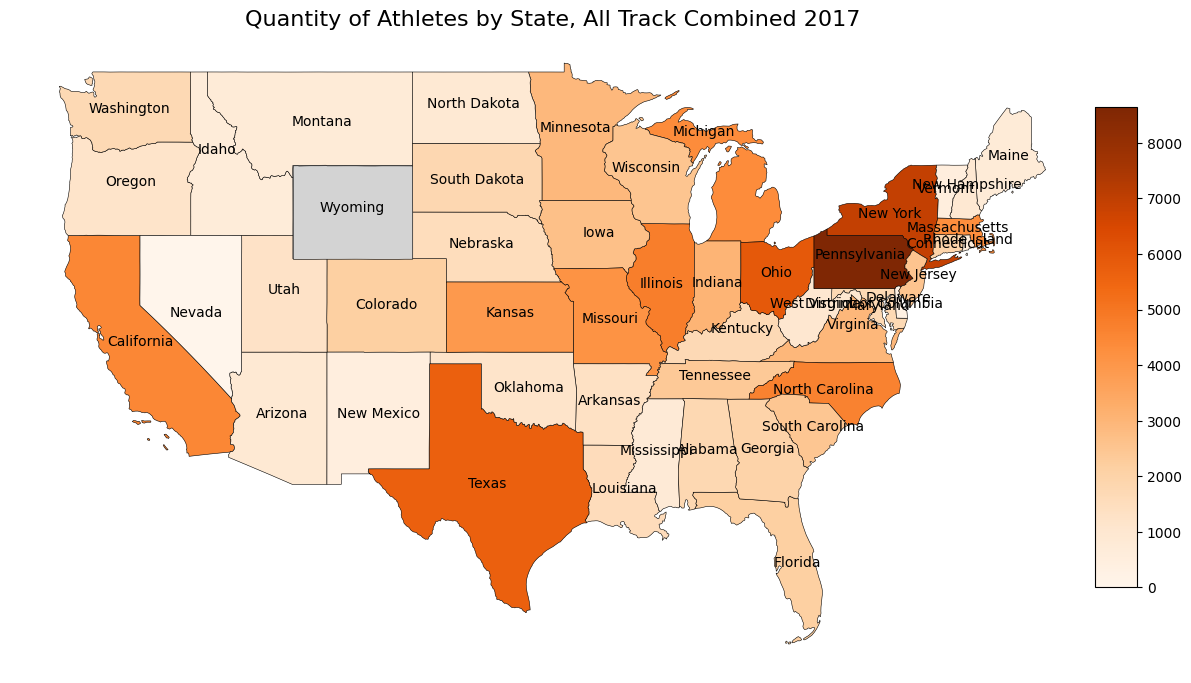

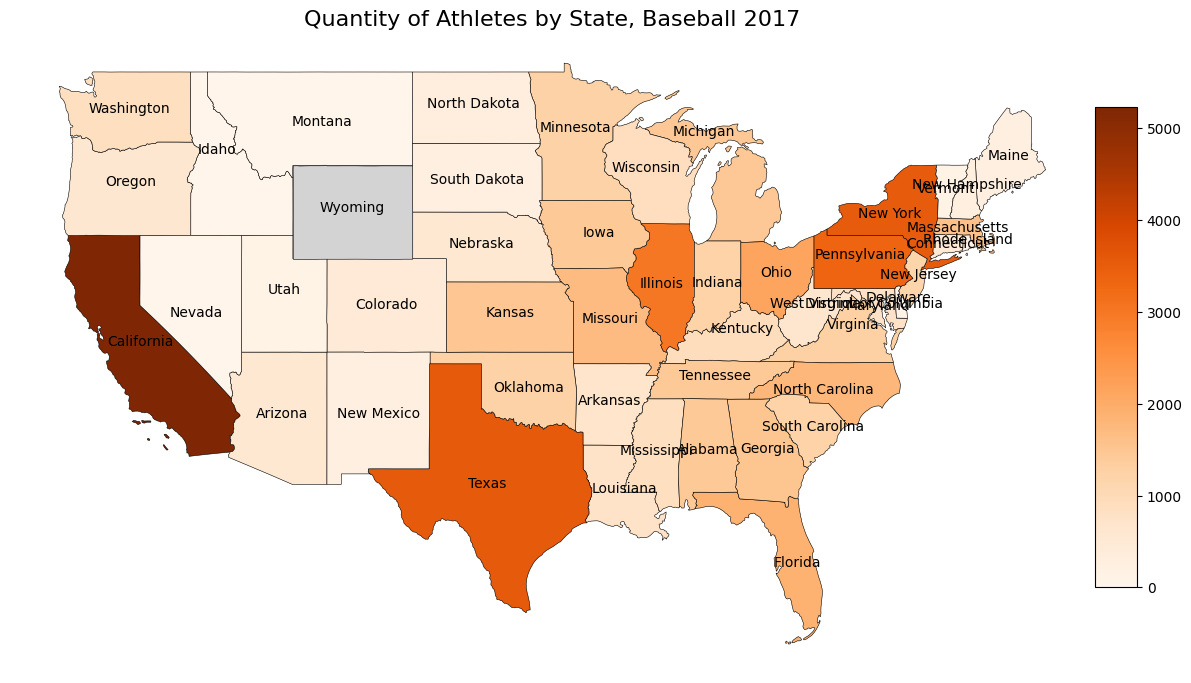

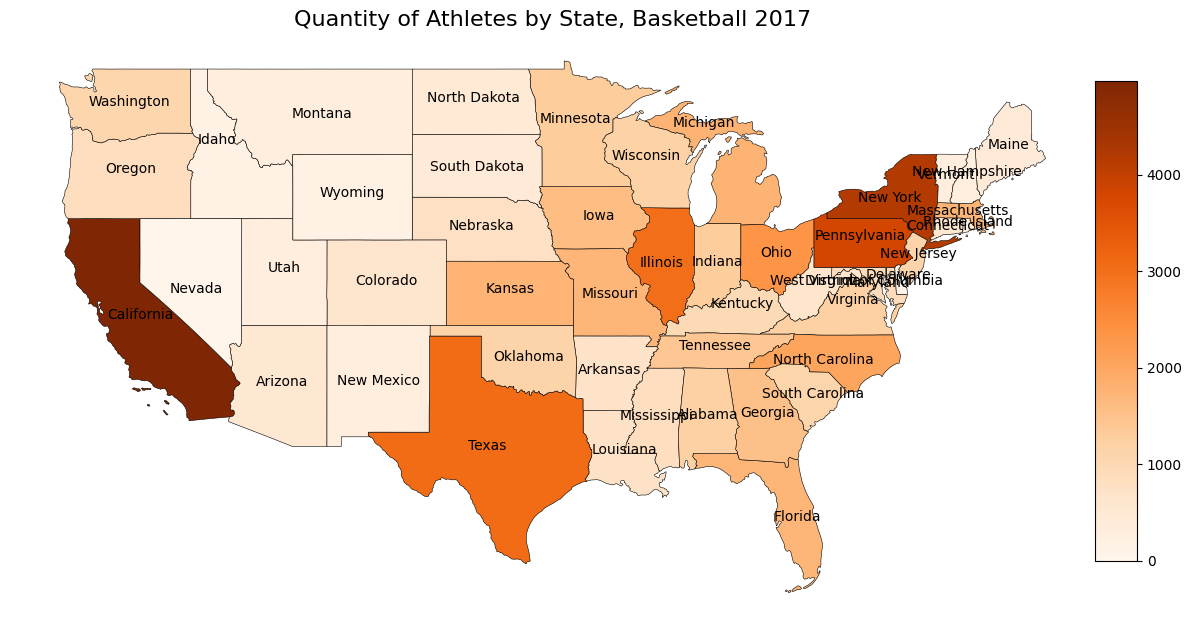

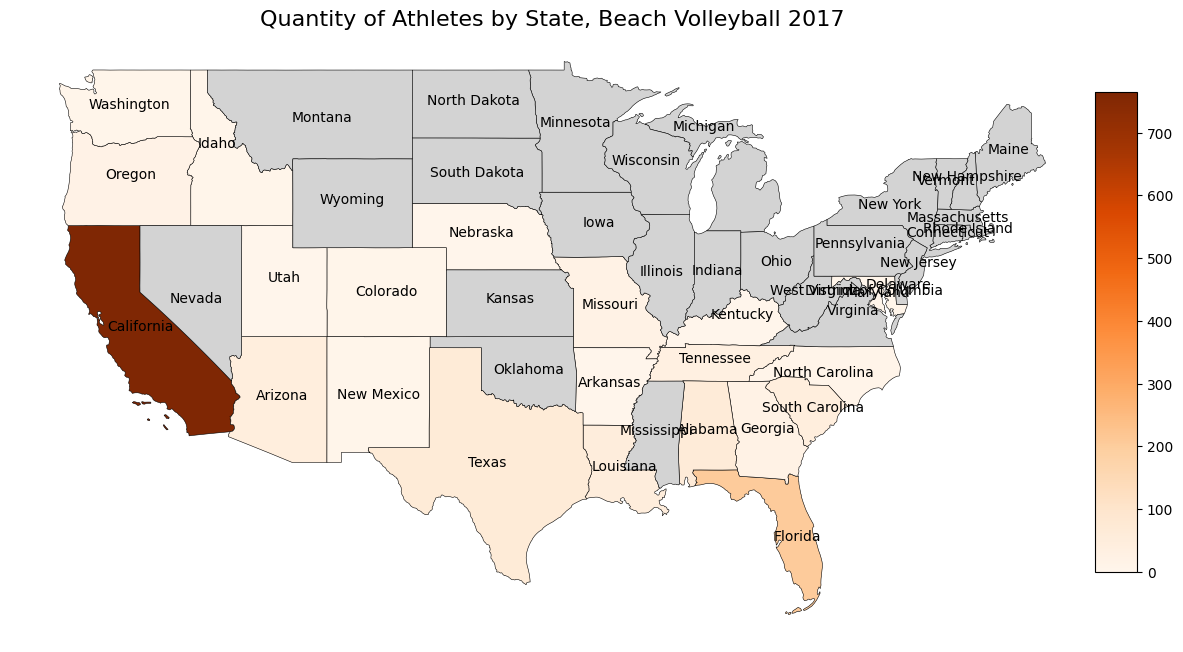

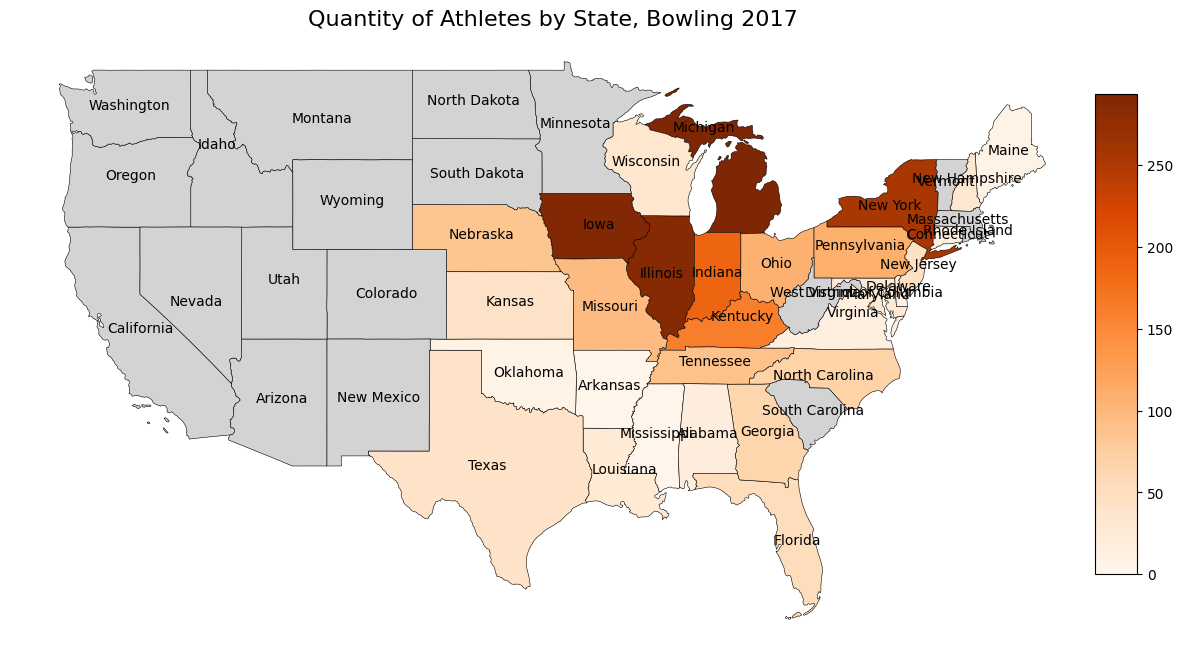

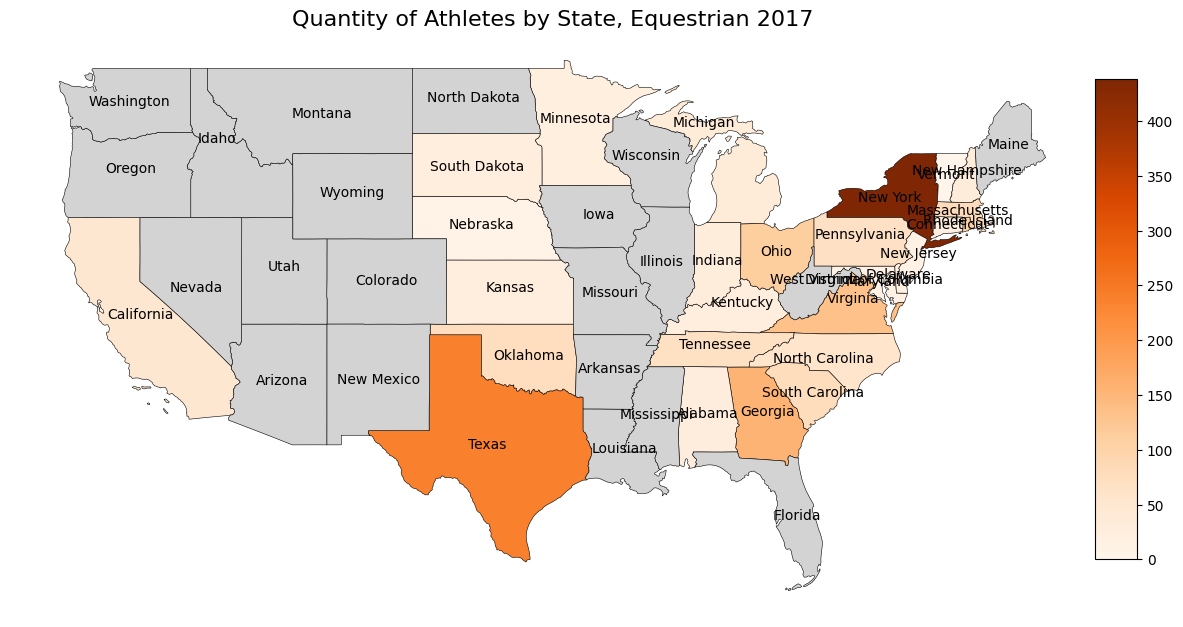

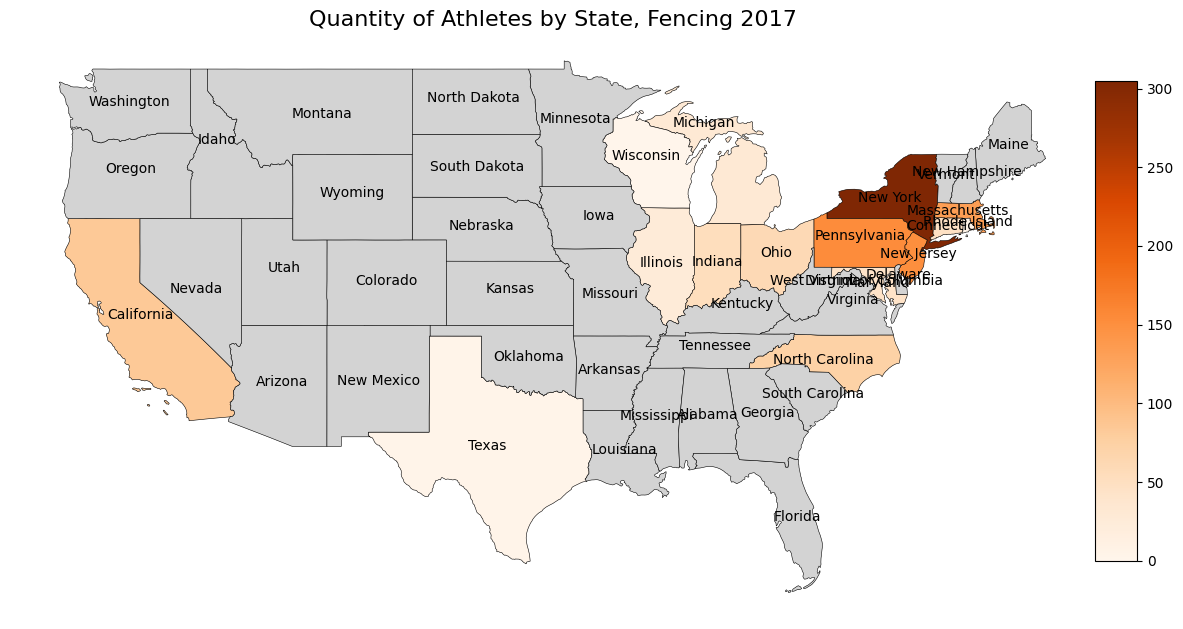

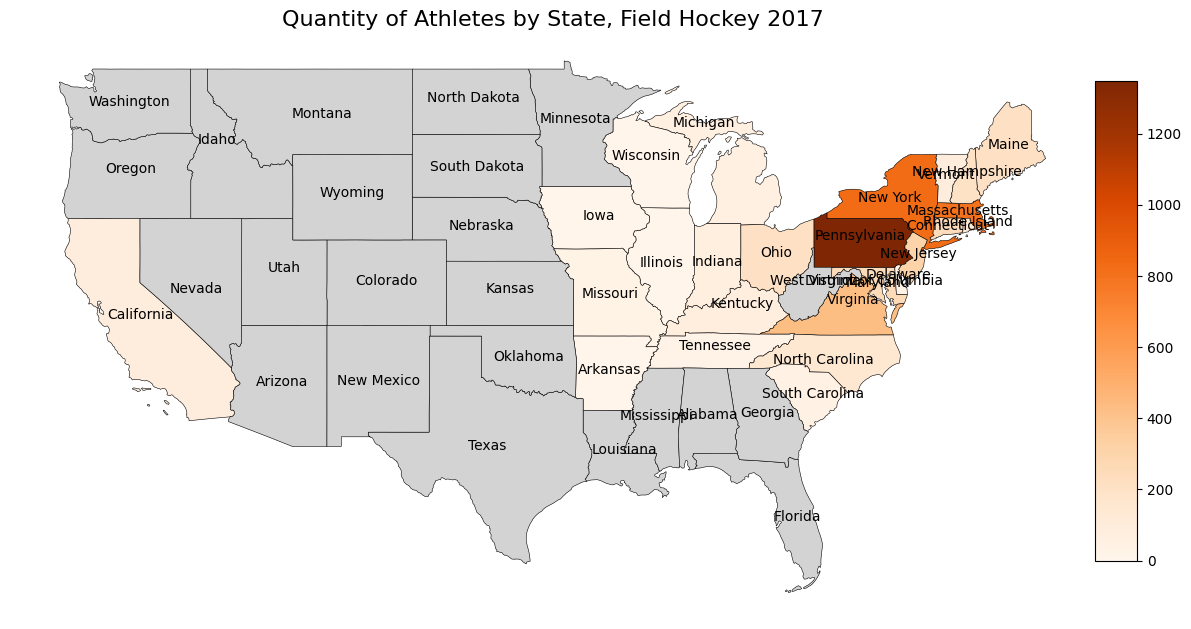

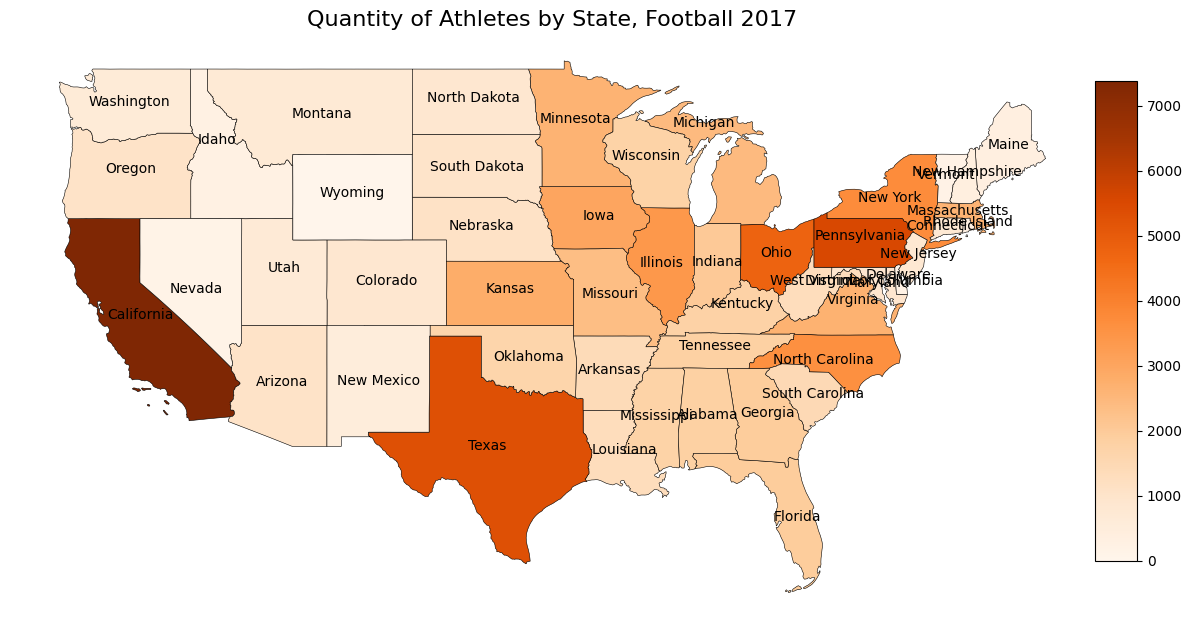

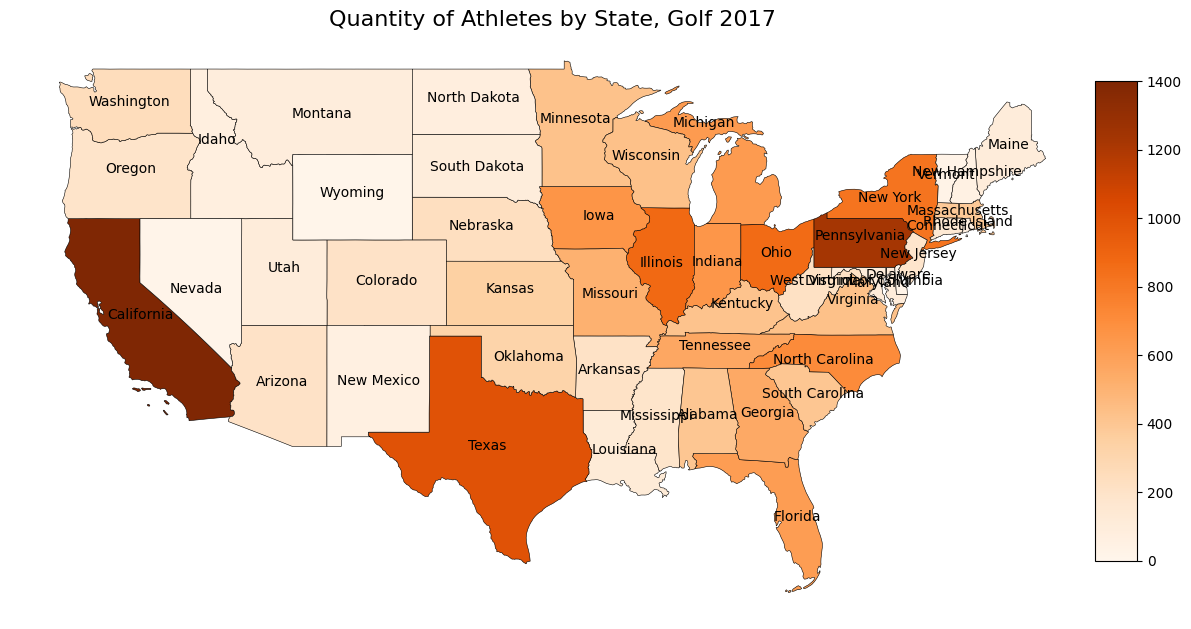

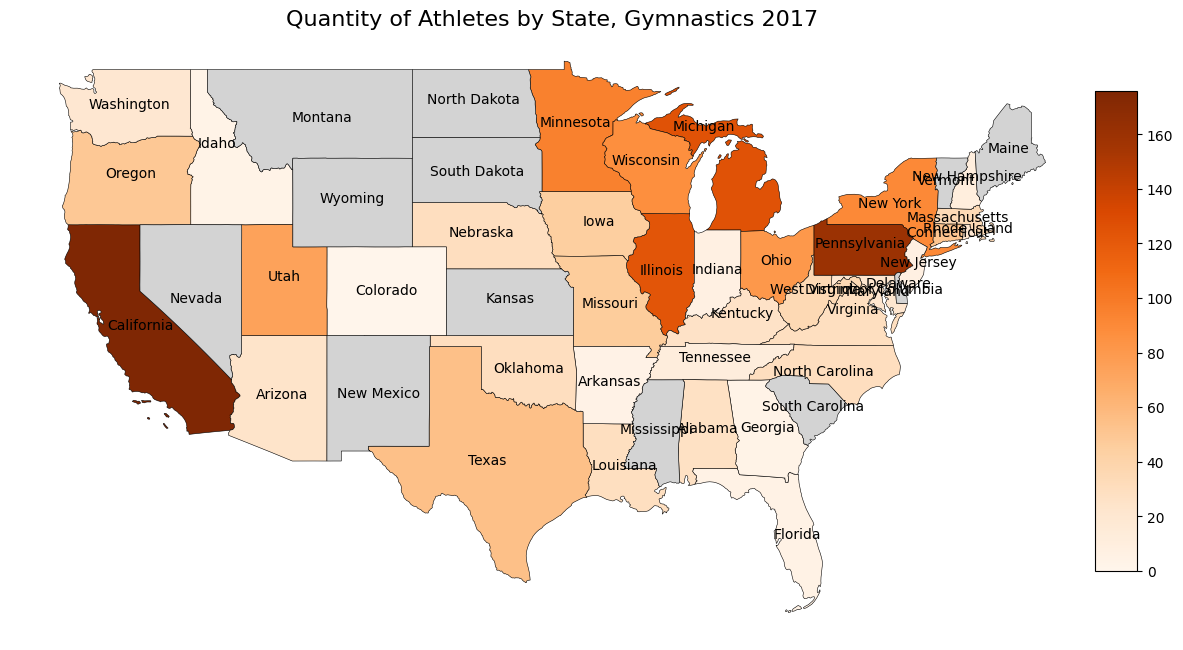

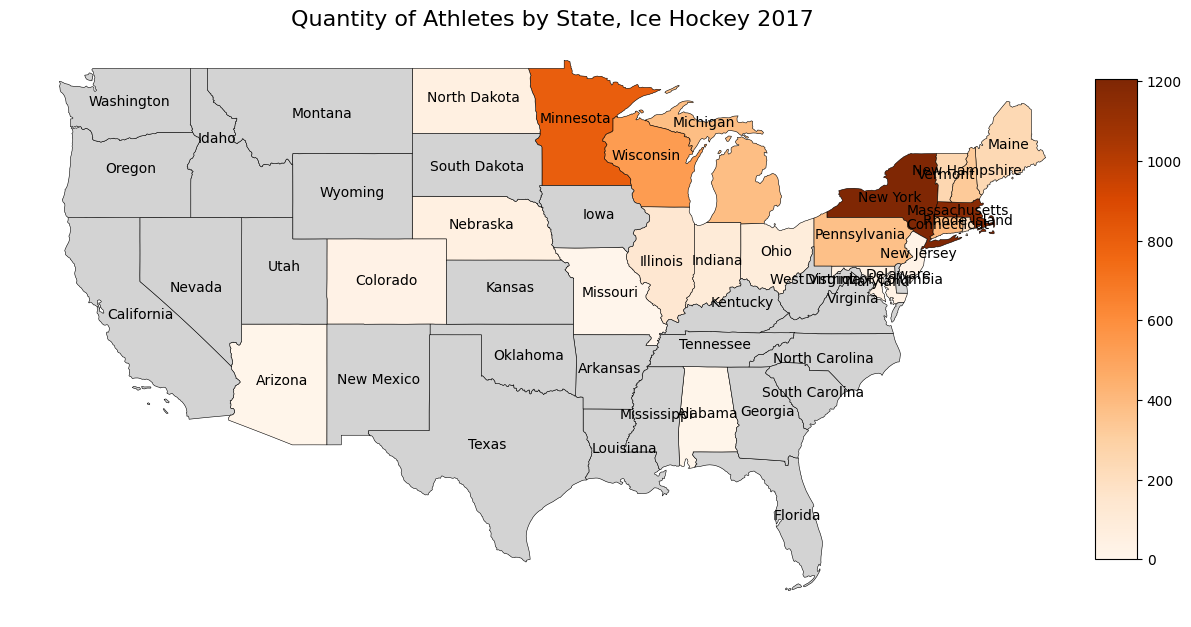

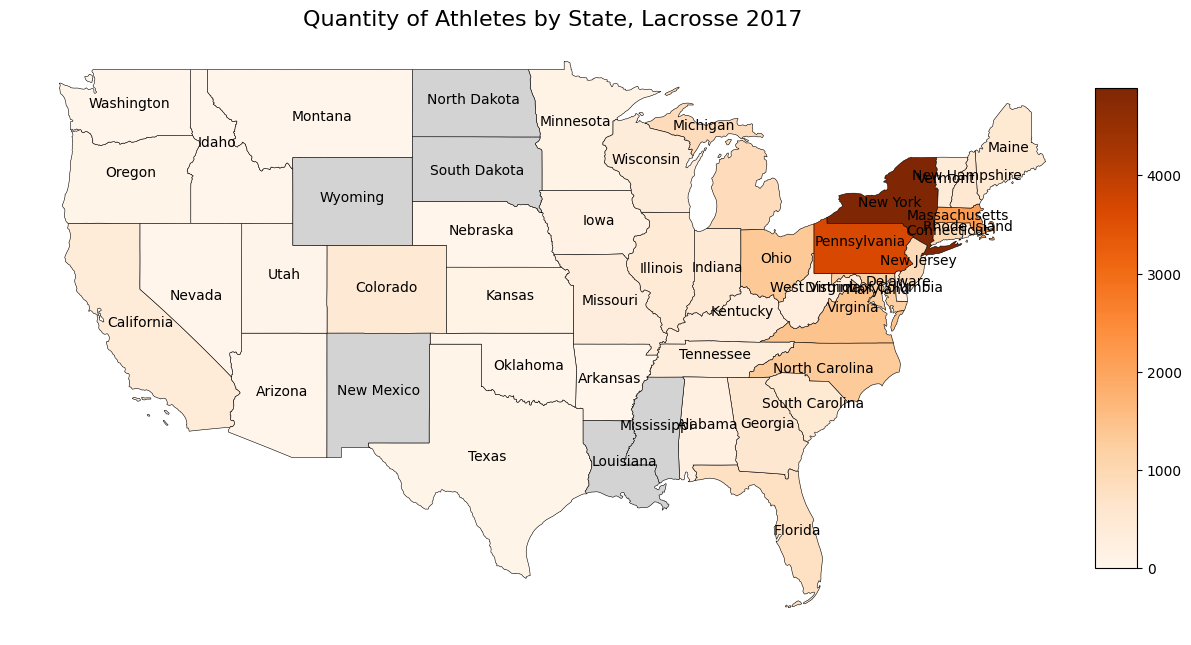

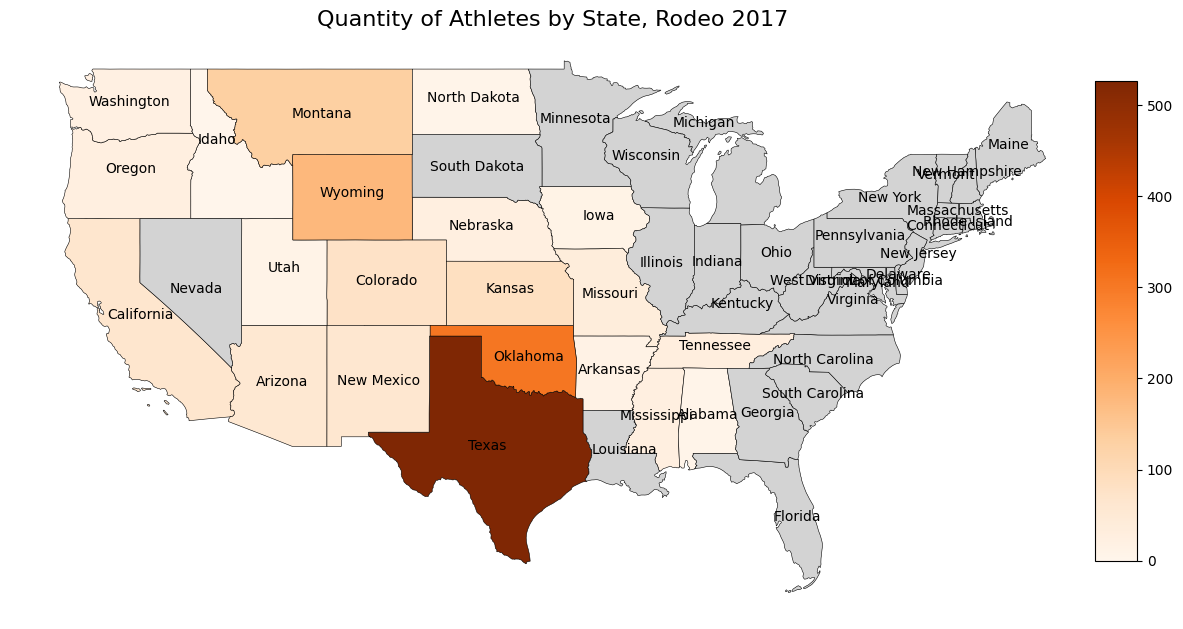

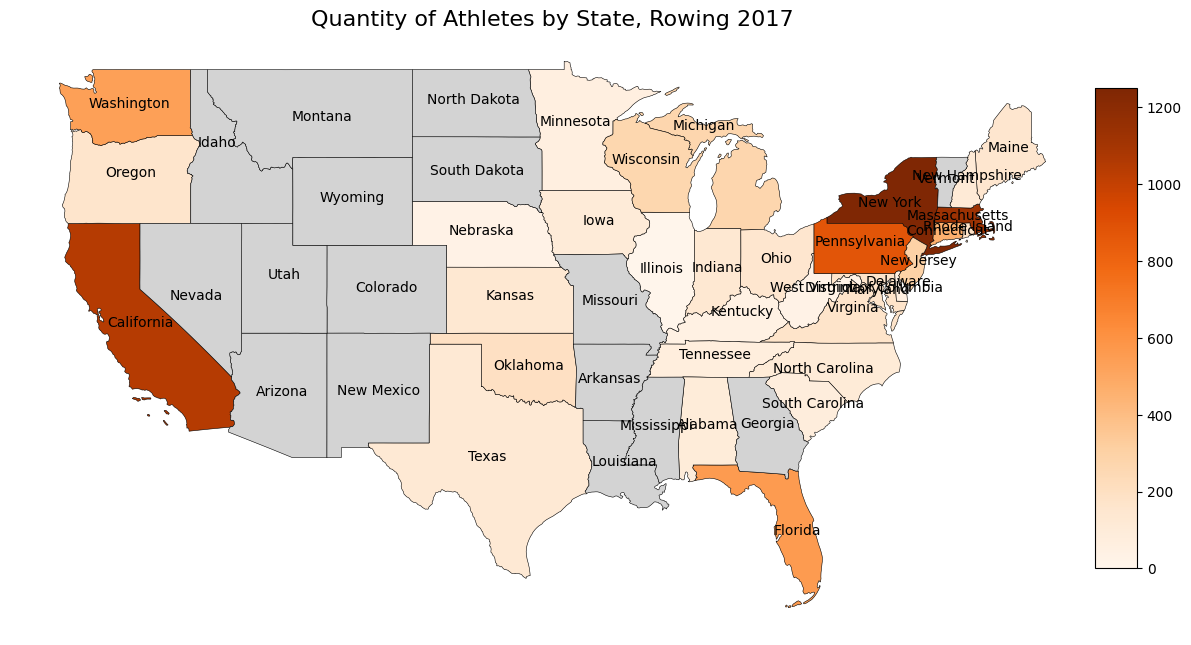

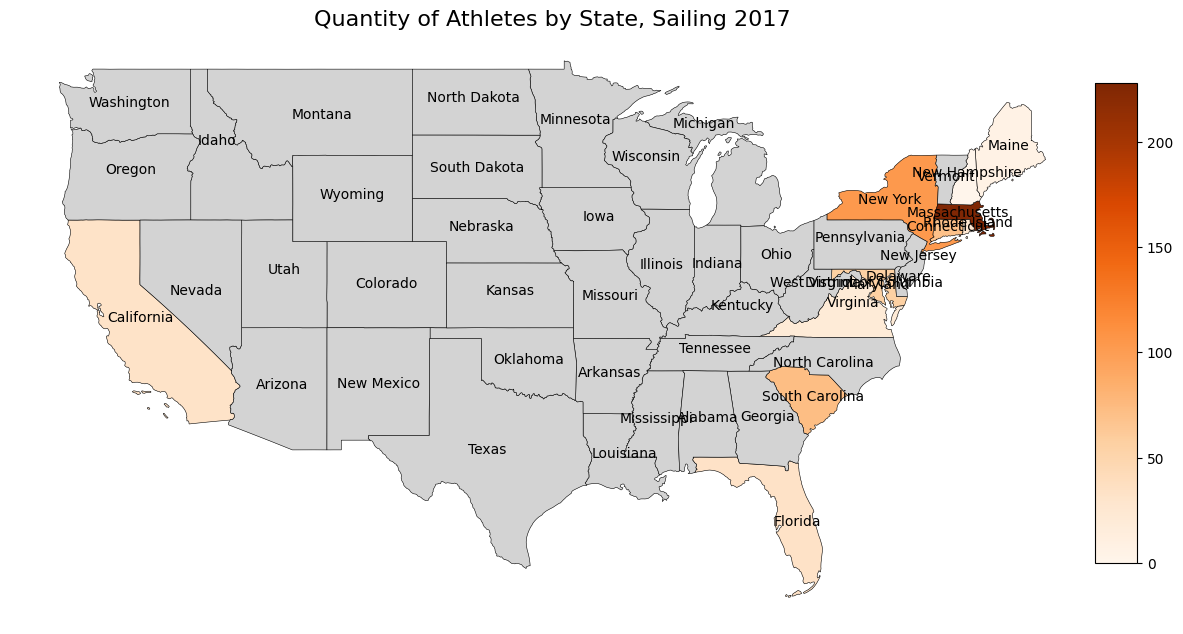

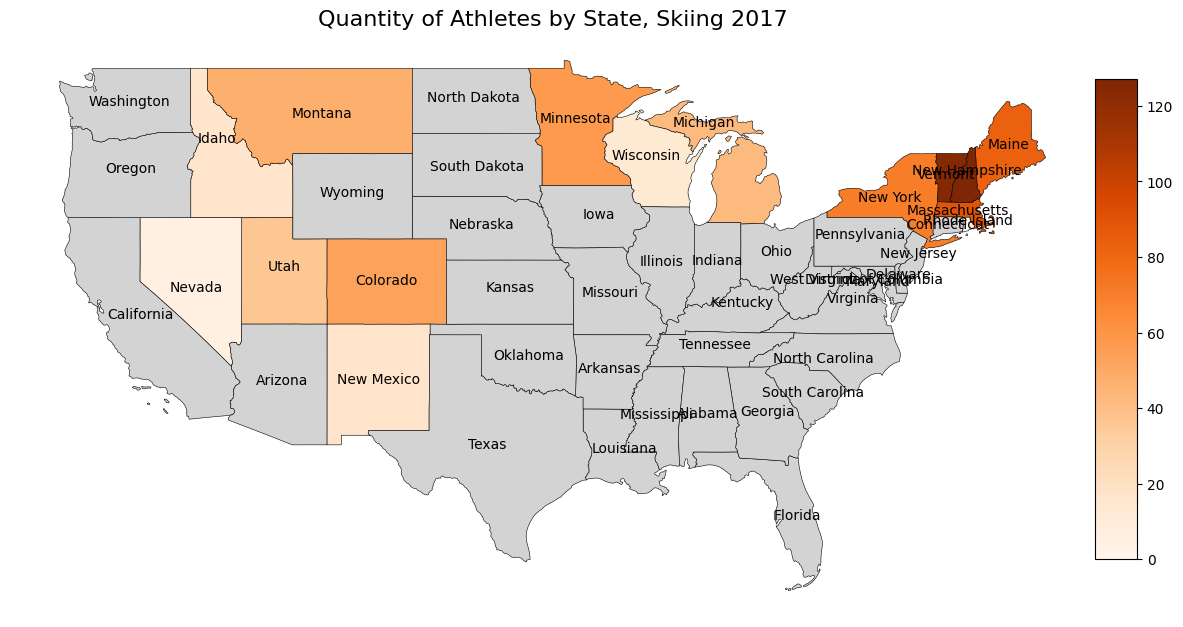

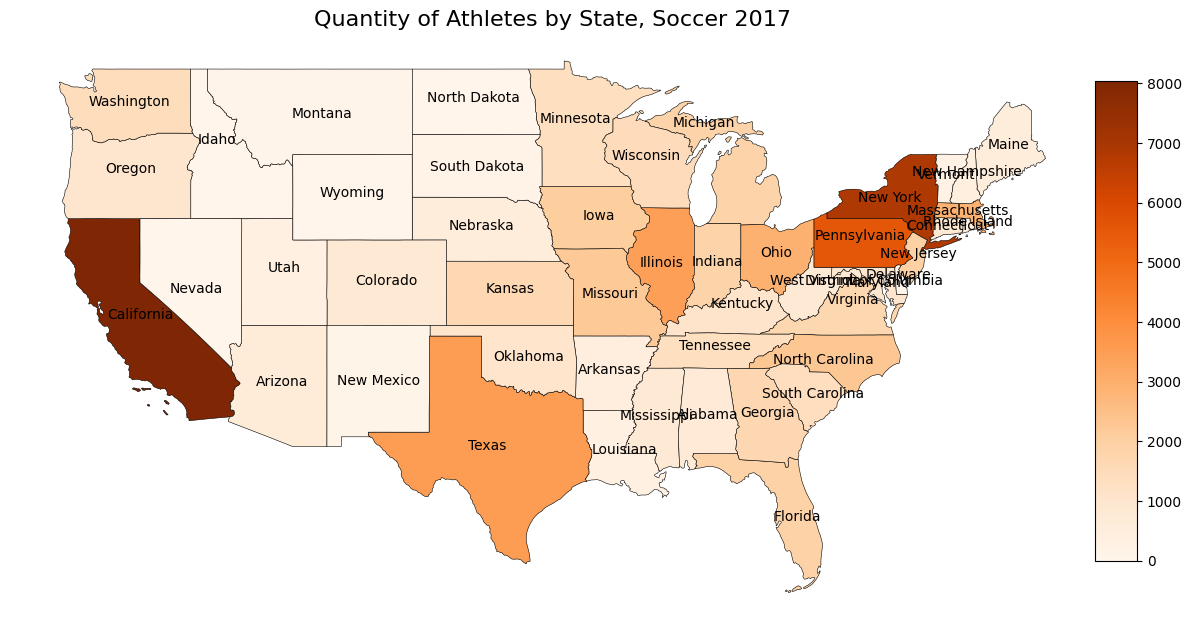

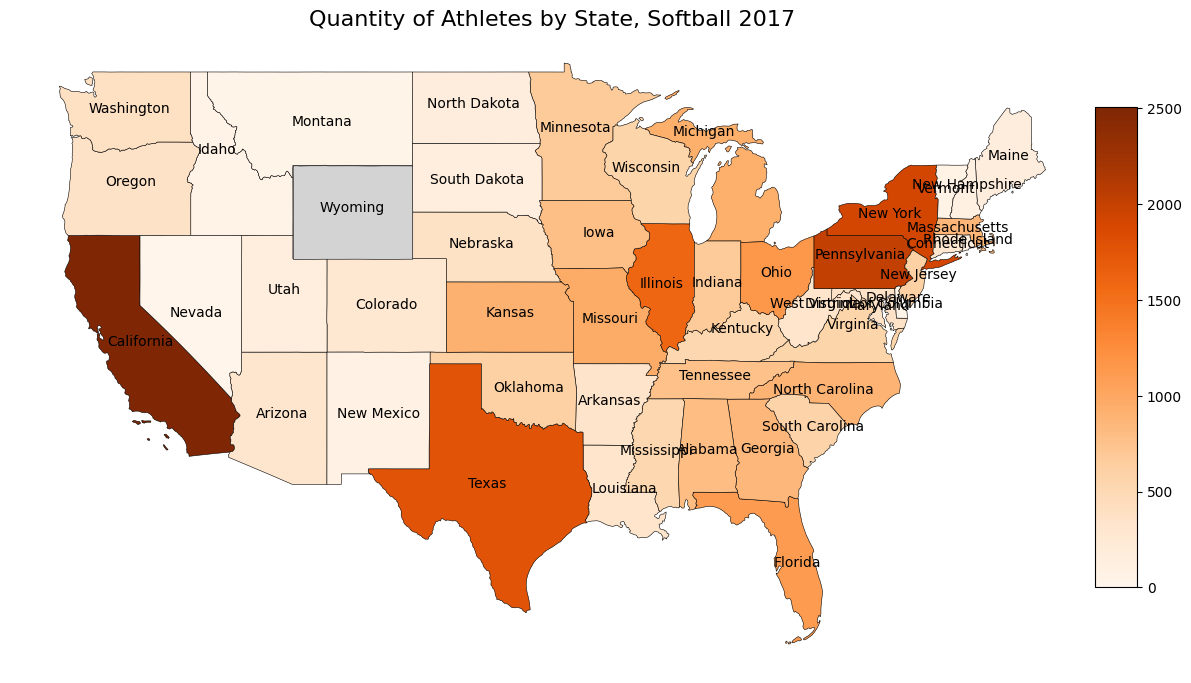

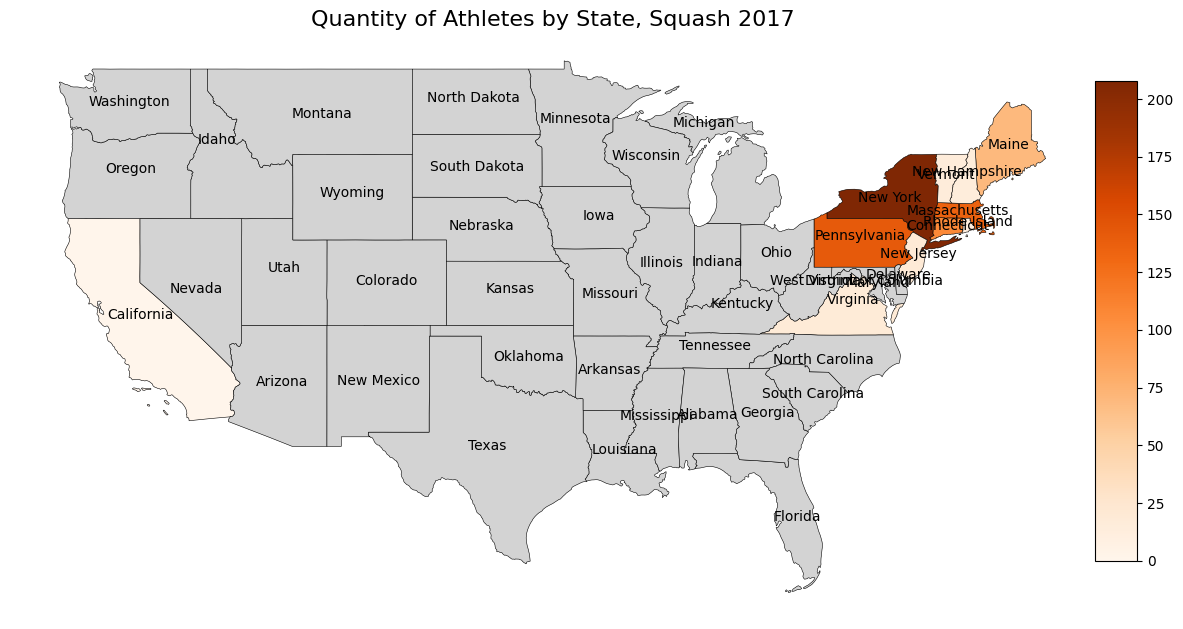

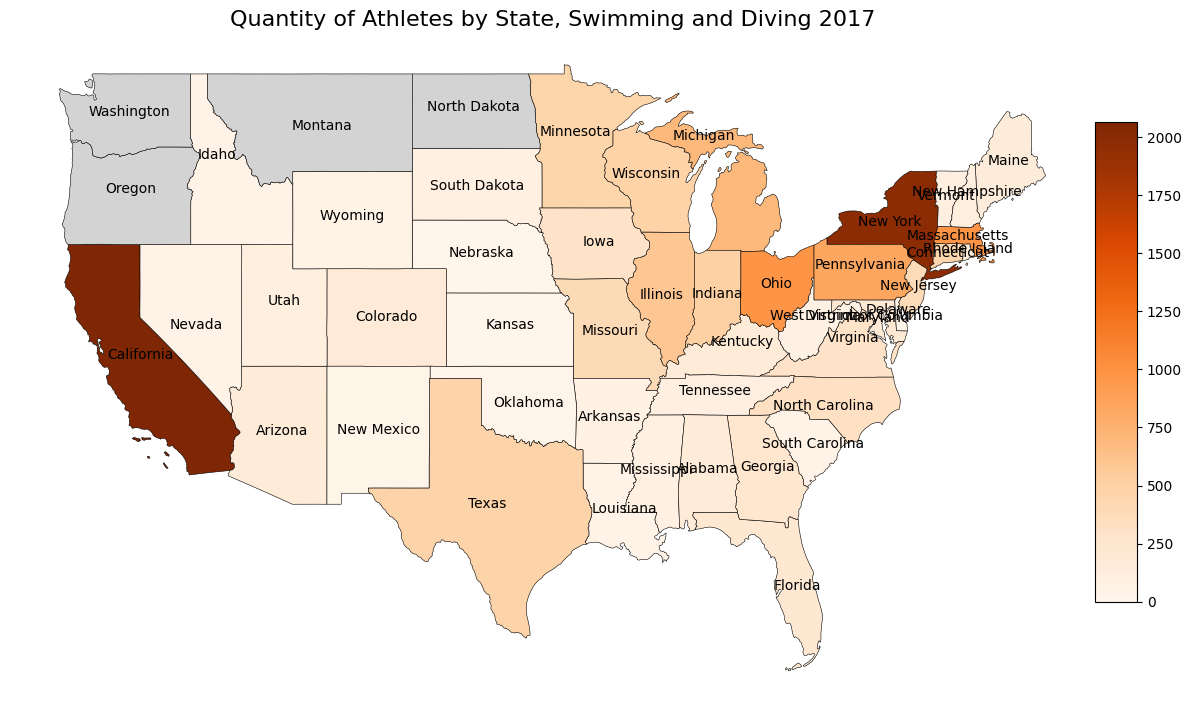

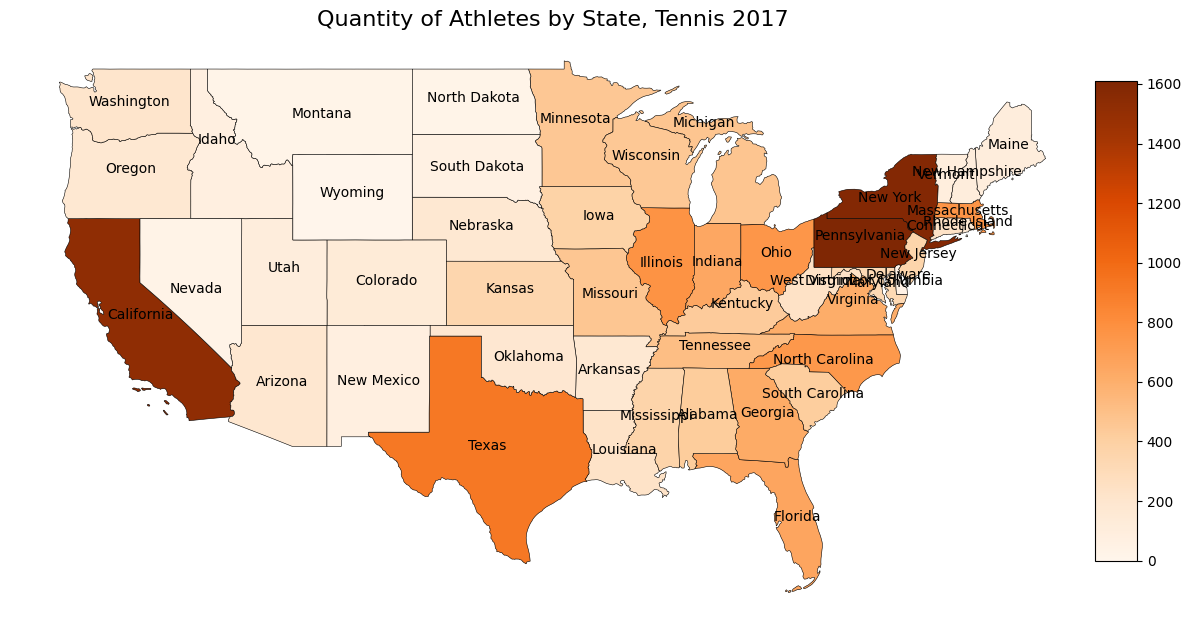

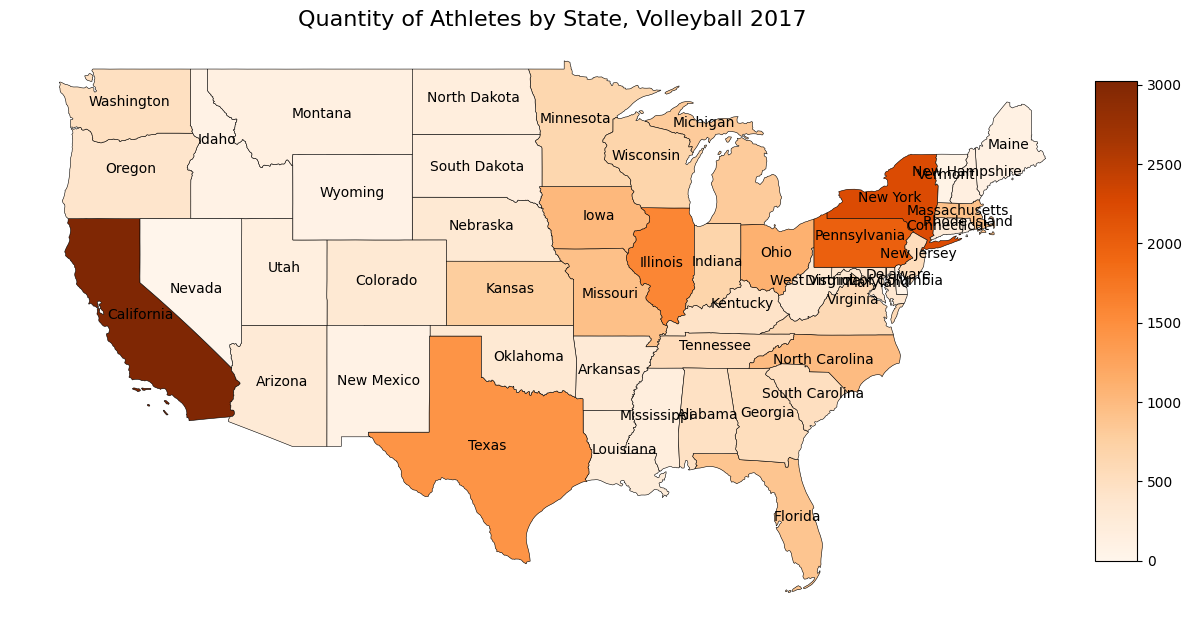

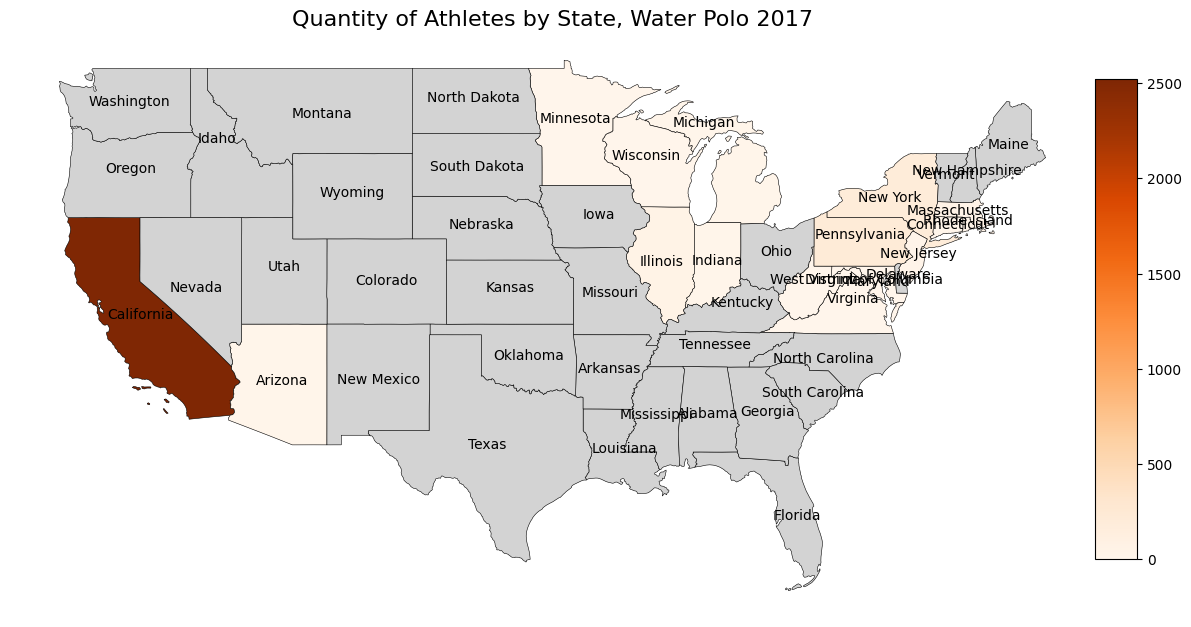

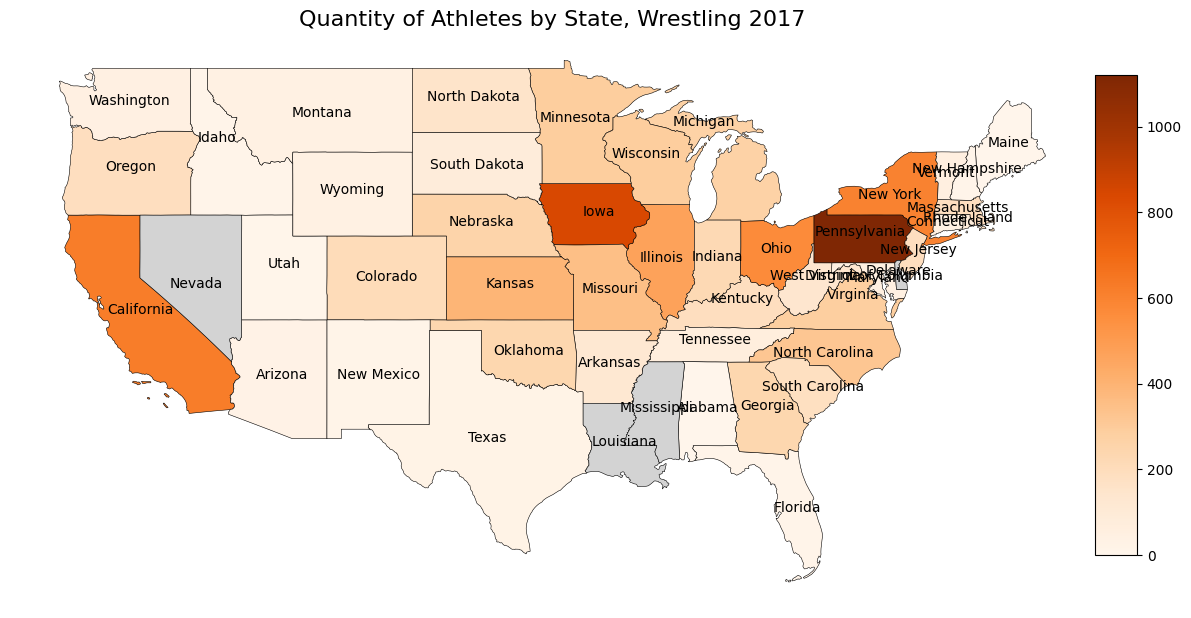

In [6]:
modalidades = data['Sports'].drop_duplicates().sort_values().reset_index(drop=True)
for sport in modalidades:
    plot_modalidade(states, data, sport, 2017)

### Gráficos de Evolução das Modalidades ao passar do tempo

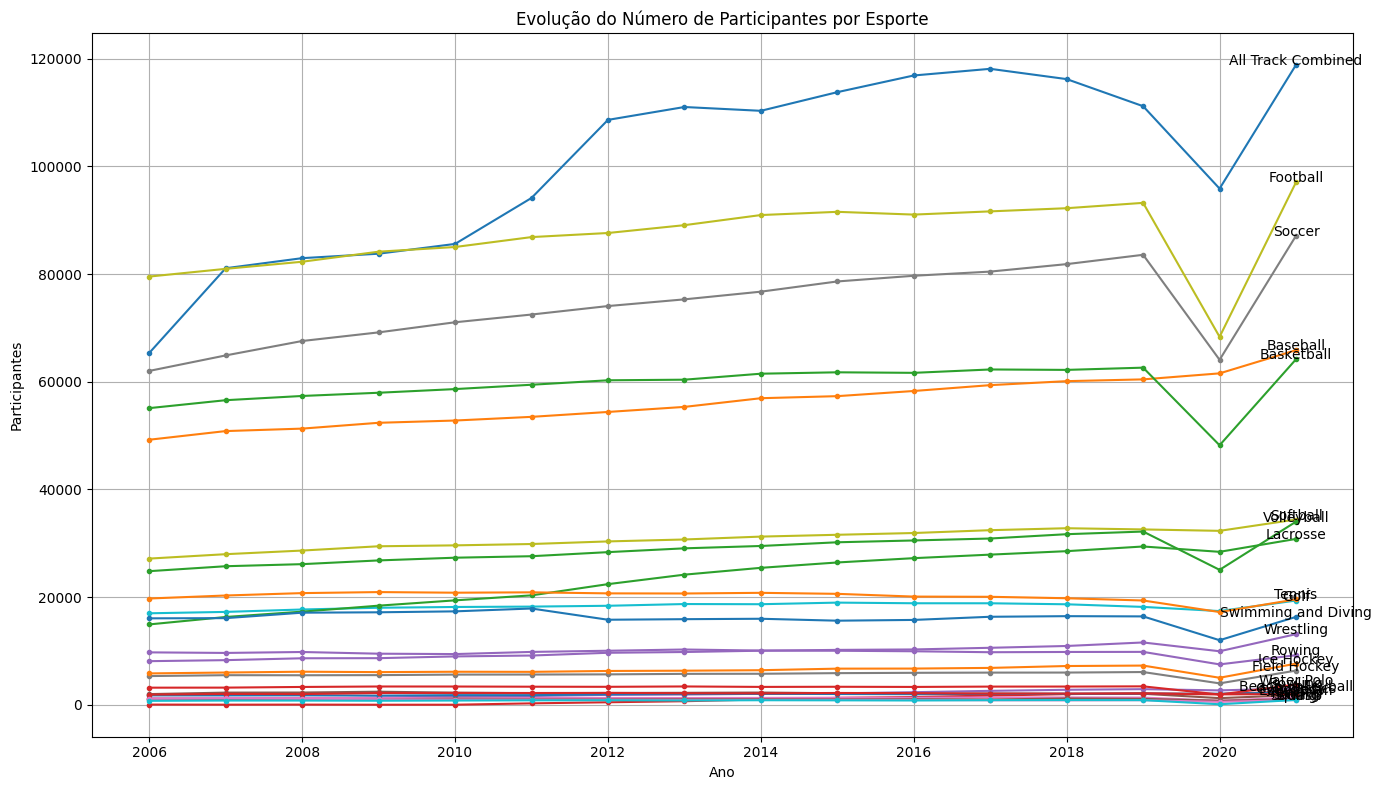

In [7]:
linhas = data.groupby(by=['YEAR', 'Sports']).sum().reset_index()
linhas = linhas.loc[:, ['YEAR', 'Sports', 'TOTAL_PARTIC']]
linhas = linhas.sort_values(by=['Sports', 'YEAR'])

esportes = linhas.groupby('Sports')

fig, ax = plt.subplots(figsize=(14, 8))

texts = []

for sport, info in esportes:
    ax.plot(info['YEAR'], info['TOTAL_PARTIC'], marker='.', linestyle='-', label=sport)

    ultimo_participantes = info.iloc[-1]['TOTAL_PARTIC']

    texts.append(ax.text(info.iloc[-1]['YEAR'], ultimo_participantes, sport, horizontalalignment='center',))

    #ax.annotate(sport, xy=(info.iloc[-1]['YEAR'], ultimo_participantes), xytext=(10, 0),
                #textcoords='offset points', ha='left', va='baseline')

ax.set_xlabel('Ano')
ax.set_ylabel('Participantes')
ax.set_title('Evolução do Número de Participantes por Esporte')
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#adjust_text(texts, time_lim=30, arrowprops=dict(arrowstyle='-', color='black', alpha=1), ax=ax)

# Exibindo o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

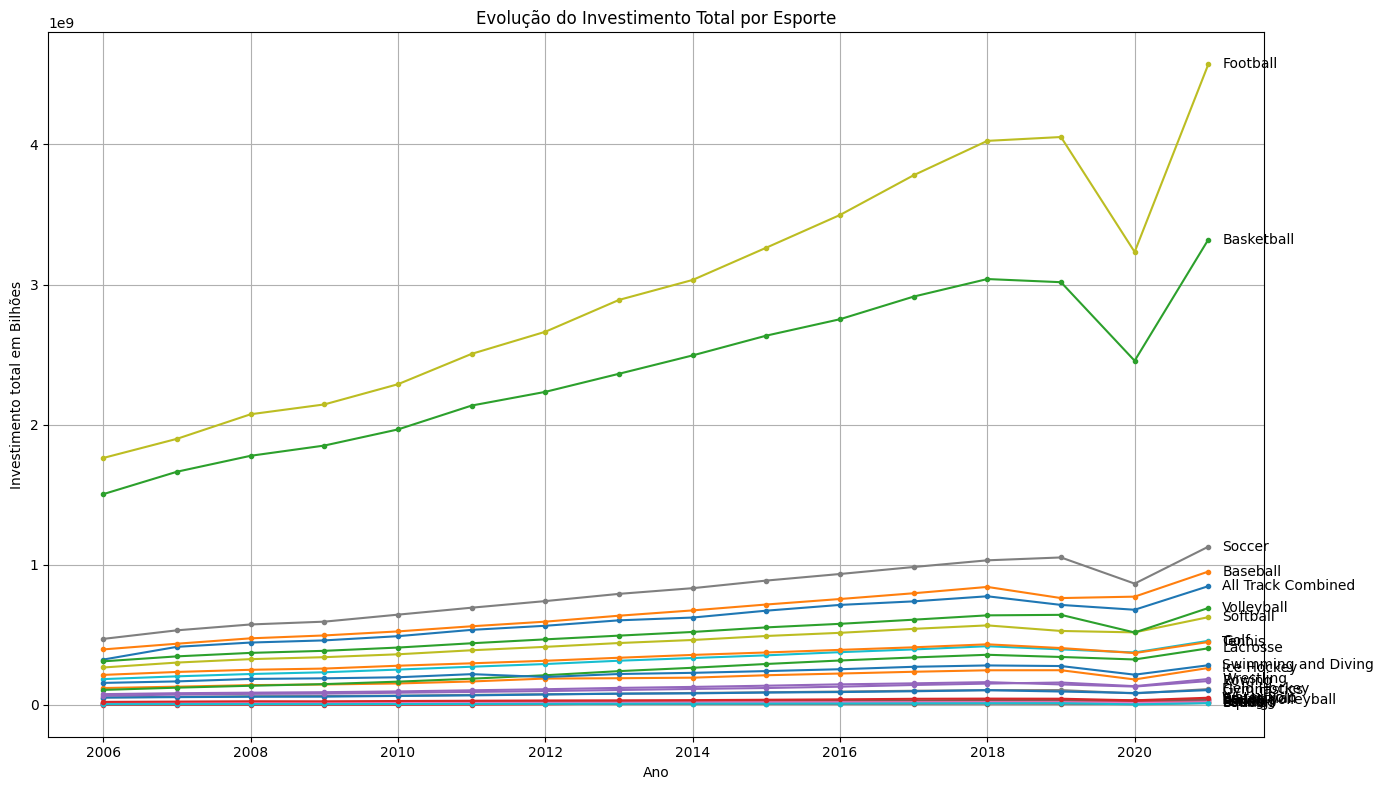

In [8]:
linhas = data.groupby(by=['YEAR', 'Sports']).sum().reset_index()
linhas = linhas.loc[:, ['YEAR', 'Sports', 'TOTAL_EXPENSE_ALL']]
linhas = linhas.sort_values(by=['Sports', 'YEAR'])

esportes = linhas.groupby('Sports')

fig, ax = plt.subplots(figsize=(14, 8))

for sport, info in esportes:
    ax.plot(info['YEAR'], info['TOTAL_EXPENSE_ALL'], marker='.', linestyle='-', label=sport)

    ultimo_participantes = info.iloc[-1]['TOTAL_EXPENSE_ALL']
    ax.annotate(sport, xy=(info.iloc[-1]['YEAR'], ultimo_participantes), xytext=(10, 0),
                textcoords='offset points', ha='left', va='center')

ax.set_xlabel('Ano')
ax.set_ylabel('Investimento total em Bilhões')
ax.set_title('Evolução do Investimento Total por Esporte')
#ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# Exibindo o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

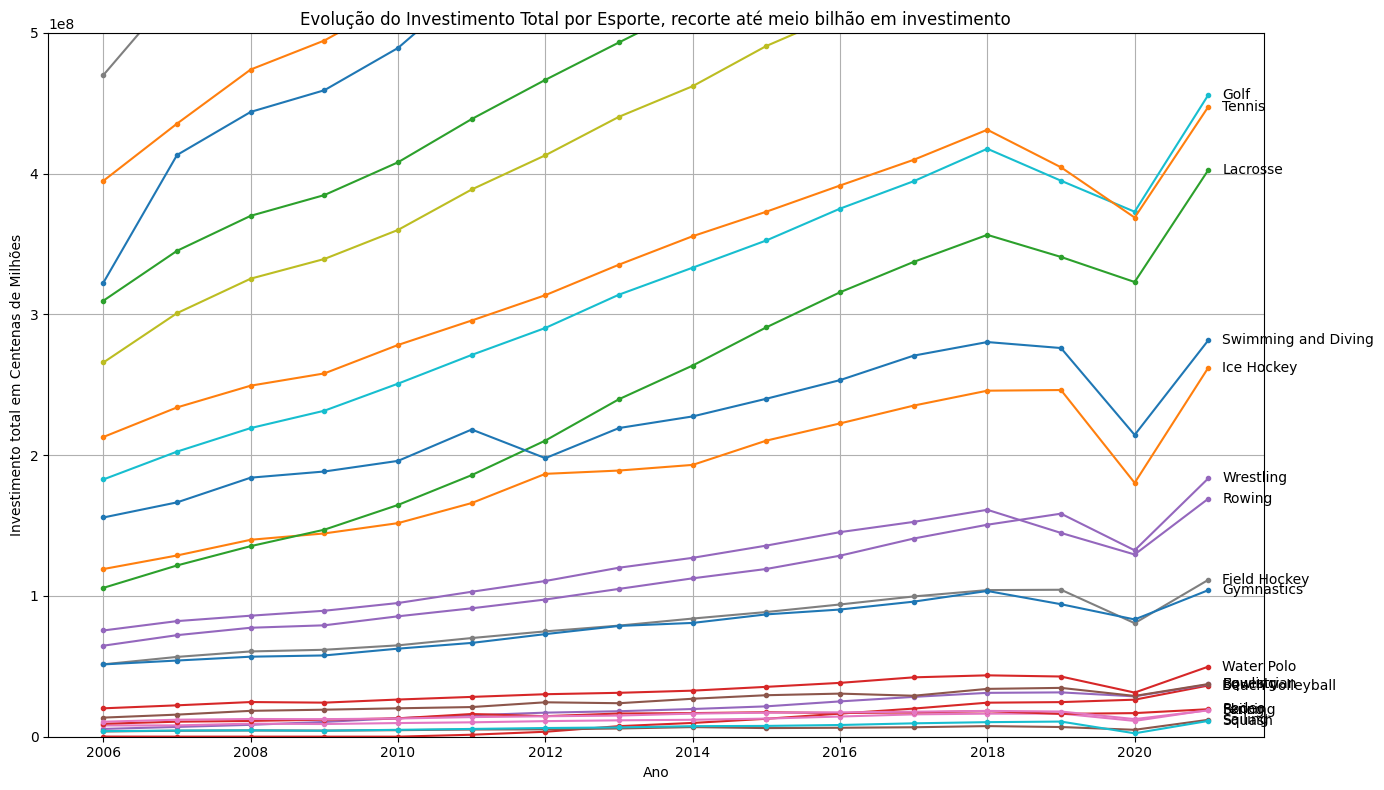

In [9]:
linhas = data.groupby(by=['YEAR', 'Sports']).sum().reset_index()
linhas = linhas.loc[:, ['YEAR', 'Sports', 'TOTAL_EXPENSE_ALL']]
linhas = linhas.sort_values(by=['Sports', 'YEAR'])

esportes = linhas.groupby('Sports')

fig, ax = plt.subplots(figsize=(14, 8))

for sport, info in esportes:
    ax.plot(info['YEAR'], info['TOTAL_EXPENSE_ALL'], marker='.', linestyle='-', label=sport)

    ultimo_participantes = info.iloc[-1]['TOTAL_EXPENSE_ALL']
    ax.annotate(sport, xy=(info.iloc[-1]['YEAR'], ultimo_participantes), xytext=(10, 0),
                textcoords='offset points', ha='left', va='center')

ax.set_xlabel('Ano')
ax.set_ylabel('Investimento total em Centenas de Milhões')
ax.set_title('Evolução do Investimento Total por Esporte, recorte até meio bilhão em investimento')
ax.set_ylim(0, 500_000_000)
#ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# Exibindo o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

### Resultados

Observamos que na questão de número de atletas, existem várias modalidades que dividem o total de atletas, porém o atletismo é a líder nesse quesito, já que é um compilado de muitas modalidades.

Apesar disso, o gráfico de investimento mostra um cenário bem diferente e muito mais desigual.
Futebol Americano e Basquete dominam o cenário em todos os anos. O Atletismo que antes era o primeiro em número de atletas, tem cerca de 12% do investimento do Futebol Americano.

É perceptível que o número de atletas tem uma certa regularidade através dos anos, os números não aumentam muito, porém o investimento tem crescido a cada ano, o que significa que o investimento por atleta tem aumentado bastante.

Todos os valores sofreram uma queda em 2020, provavelmente em decorrência da pandemia de Covid-19.

## Intervalo de Confiança

In [10]:
def bootstrap_mean(df, column, n=5000, size=None):
    '''
    Faz um boostrap da média da coluna escolhida. Gera amostras.

    Parâmetros
    ----------
    df: o dataframe
    column: a coluna que queremos focar
    n: número de amostras para o bootstrap
    size: tamanho de cada amostra, por padrão vira o tamanho do df.
    '''
    if size is None:
        size = len(df)
    values = np.zeros(n)
    for i in range(n):
        sample = df[column].sample(size, replace=True)
        values[i] = sample.mean()
    return values

### A liderança em popularidade do Futebol Americano pode ser explicada pelo acaso?

O boxplot que mostra os intervalos de confiança mostra que não, o intervalo de bootstrap do Futebol Americano é muito distinto dos outros esportes, ou seja, do ponto de vista estatístico, existe um claro viés que influencia no investimento do esporte. 

O plot seguinte mostra a mesma relação, porém analisada sobre os investimentos em atletismo, este mostra que o atletismo está contido no intervalo de confiança, logo o acaso explica seus valores de investimento.

<Axes: >

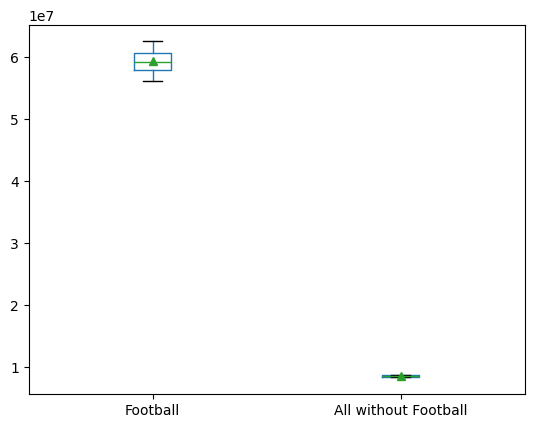

In [11]:
football = data.loc[data["Sports"] == "Football"]
no_football = data.loc[data["Sports"] != "Football"]

football_mean = bootstrap_mean(football, "TOTAL_EXPENSE_ALL")
all_mean = bootstrap_mean(no_football, "TOTAL_EXPENSE_ALL")

to_plot = pd.DataFrame()
to_plot['Football'] = football_mean
to_plot['All without Football'] = all_mean

to_plot.boxplot(grid=False, sym='', whis=[5, 95], showmeans=True)

<Axes: >

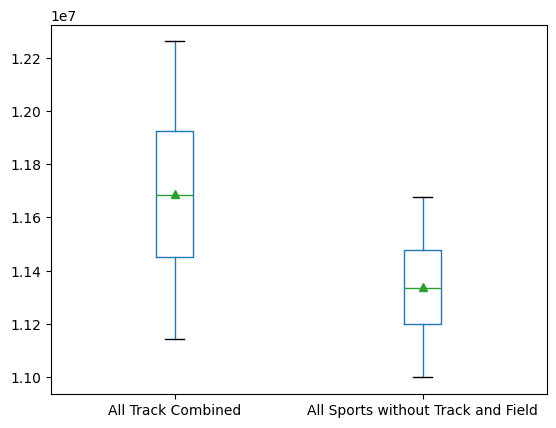

In [12]:
atletismo = data.loc[data["Sports"] == "All Track Combined"]
all = data.loc[data["Sports"] != "All Track Combined"]

atletismo_mean = bootstrap_mean(atletismo, "TOTAL_EXPENSE_ALL")
all_mean = bootstrap_mean(all, "TOTAL_EXPENSE_ALL")

to_plot = pd.DataFrame()
to_plot['All Track Combined'] = atletismo_mean
to_plot['All Sports without Track and Field'] = all_mean

to_plot.boxplot(grid=False, sym='', whis=[5, 95], showmeans=True)